### MLP

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split

In [2]:
im_fol = os.path.join("D:/Users/James/Documents/Jupyter Saves/University/7088CEM/archive/")

In [3]:
im_fol = os.path.join("D:/Users/James/Documents/Jupyter Saves/University/7088CEM/archive/")
tum_types = ["no_tumor", "meningioma_tumor", "pituitary_tumor", "glioma_tumor"]

# Training Data
for ty in tum_types:
    ty_fol = os.path.join(im_fol, "Training", ty)
    for file in os.listdir(ty_fol):
        im_path = os.path.join(ty_fol, file)
        im = cv2.imread(im_path)

im = cv2.resize(im, (512,512))        



training = []

for ty in tum_types:
    ty_fol = os.path.join(im_fol, "Training", ty)
    tum_num = tum_types.index(ty)
    for file in os.listdir(ty_fol):
        image_arr = cv2.imread(os.path.join(ty_fol, file), cv2.IMREAD_GRAYSCALE)
        new_image_array = cv2.resize(image_arr, (128, 128))
        training.append([new_image_array , tum_num])

        
        
        
# Testing Data
testing = []

for ty in tum_types:
    ty_fol = os.path.join(im_fol, "Testing", ty)
    tum_num = tum_types.index(ty)
    for file in os.listdir(ty_fol):
        image_arr = cv2.imread(os.path.join(ty_fol, file), cv2.IMREAD_GRAYSCALE)
        new_image_array = cv2.resize(image_arr, (128, 128))
        testing.append([new_image_array , tum_num])

In [4]:
# Training
x_train = []
y_train = []

for i, j in training:
    x_train.append(i)
    y_train.append(j)
    
x_train = np.array(x_train).reshape(-1, 128, 128)
print(x_train.shape)

x_train = x_train/255
x_train = x_train.reshape(-1, 128, 128, 1)



# Validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train , test_size = 0.1, random_state = 123)



# Testing
x_test = []
y_test = []

for i, j in testing:
    x_test.append(i)
    y_test.append(j)

x_test = np.array(x_test).reshape(-1, 128, 128)
print(x_test.shape)

x_test = x_test/255
x_test = x_test.reshape(-1, 128, 128, 1)

(2870, 128, 128)
(394, 128, 128)


In [5]:
from keras.utils.np_utils import to_categorical   

y_train_enc = to_categorical(y_train, num_classes = 4)
y_val_enc = to_categorical(y_val, num_classes = 4)
y_test_enc = to_categorical(y_test, num_classes = 4)

In [6]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

In [7]:
from keras.layers.normalization import BatchNormalization

input_shape = (128, 128, 1)
num_classes = 4

model = Sequential()
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

#model.add(BatchNormalization())
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.20))

model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# With data augmentation to prevent overfitting 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 2,163,844
Trainable params: 2,130,820
Non-trainable params: 33,024
_________________________________________

In [8]:
## Fit the model
epochs = 100
batch_size = 32

#history = model.fit(datagen.flow(x_train, y_train_enc, batch_size=batch_size),
#                              epochs = epochs, validation_data = (x_val, y_val_enc),
#                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
#                              callbacks=[learning_rate_reduction])
                              
                              
history = model.fit(x_train, y_train_enc, epochs=epochs)

loss, accuracy = model.evaluate(x_test, y_test_enc, verbose=1)
loss_v, accuracy_v = model.evaluate(x_val, y_val_enc, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Epoch 1/100
81/81 [==============================] - 1s 12ms/step - loss: 1.0666 - accuracy: 0.6358 0s - loss: 1.255
Epoch 2/100
81/81 [==============================] - 1s 10ms/step - loss: 0.5064 - accuracy: 0.8167
Epoch 3/100
81/81 [==============================] - 1s 11ms/step - loss: 0.3674 - accuracy: 0.8703
Epoch 4/100
81/81 [==============================] - 1s 11ms/step - loss: 0.2901 - accuracy: 0.9000
Epoch 5/100
81/81 [==============================] - 1s 10ms/step - loss: 0.2229 - accuracy: 0.9315
Epoch 6/100
81/81 [==============================] - 1s 10ms/step - loss: 0.1661 - accuracy: 0.9442
Epoch 7/100
81/81 [==============================] - 1s 10ms/step - loss: 0.1814 - accuracy: 0.9435
Epoch 8/100
81/81 [==============================] - 1s 10ms/step - loss: 0.1216 - accuracy: 0.9635
Epoch 9/100
81/81 [==============================] - 1s 11ms/step - loss: 0.1093 - accuracy: 0.9637
Epoch 10/100
81/81 [==============================] - 1s 12ms/step - loss: 0.1057 -

81/81 [==============================] - 1s 10ms/step - loss: 0.0114 - accuracy: 0.9965
Epoch 82/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0200 - accuracy: 0.9923
Epoch 83/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0199 - accuracy: 0.9923
Epoch 84/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0318 - accuracy: 0.9904
Epoch 85/100
81/81 [==============================] - 1s 11ms/step - loss: 0.0124 - accuracy: 0.9976
Epoch 86/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0254 - accuracy: 0.9945
Epoch 87/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0474 - accuracy: 0.9833
Epoch 88/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0366 - accuracy: 0.9861
Epoch 89/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0502 - accuracy: 0.9878
Epoch 90/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0282 - accuracy: 0.9902
Epo

### Evalutations

In [9]:
score = model.evaluate(x_train, y_train_enc)
score

81/81 [==============================] - 0s 2ms/step - loss: 2.2856e-04 - accuracy: 1.0000


[0.00022855545103084296, 1.0]

In [10]:
score = model.evaluate(x_val, y_val_enc)
score

9/9 [==============================] - 0s 2ms/step - loss: 0.3890 - accuracy: 0.9164


[0.3889859914779663, 0.9163762927055359]

In [11]:
score = model.evaluate(x_test, y_test_enc)
score

13/13 [==============================] - 0s 2ms/step - loss: 3.5437 - accuracy: 0.7360


[3.5436558723449707, 0.7360405921936035]

### Confusion Matrices

In [13]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 45)
#    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 30)
    plt.yticks(tick_marks, classes, fontsize = 30)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], fontsize = 45,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 45)
    plt.xlabel('Predicted label', fontsize = 45)


### Validation Data Con Mat

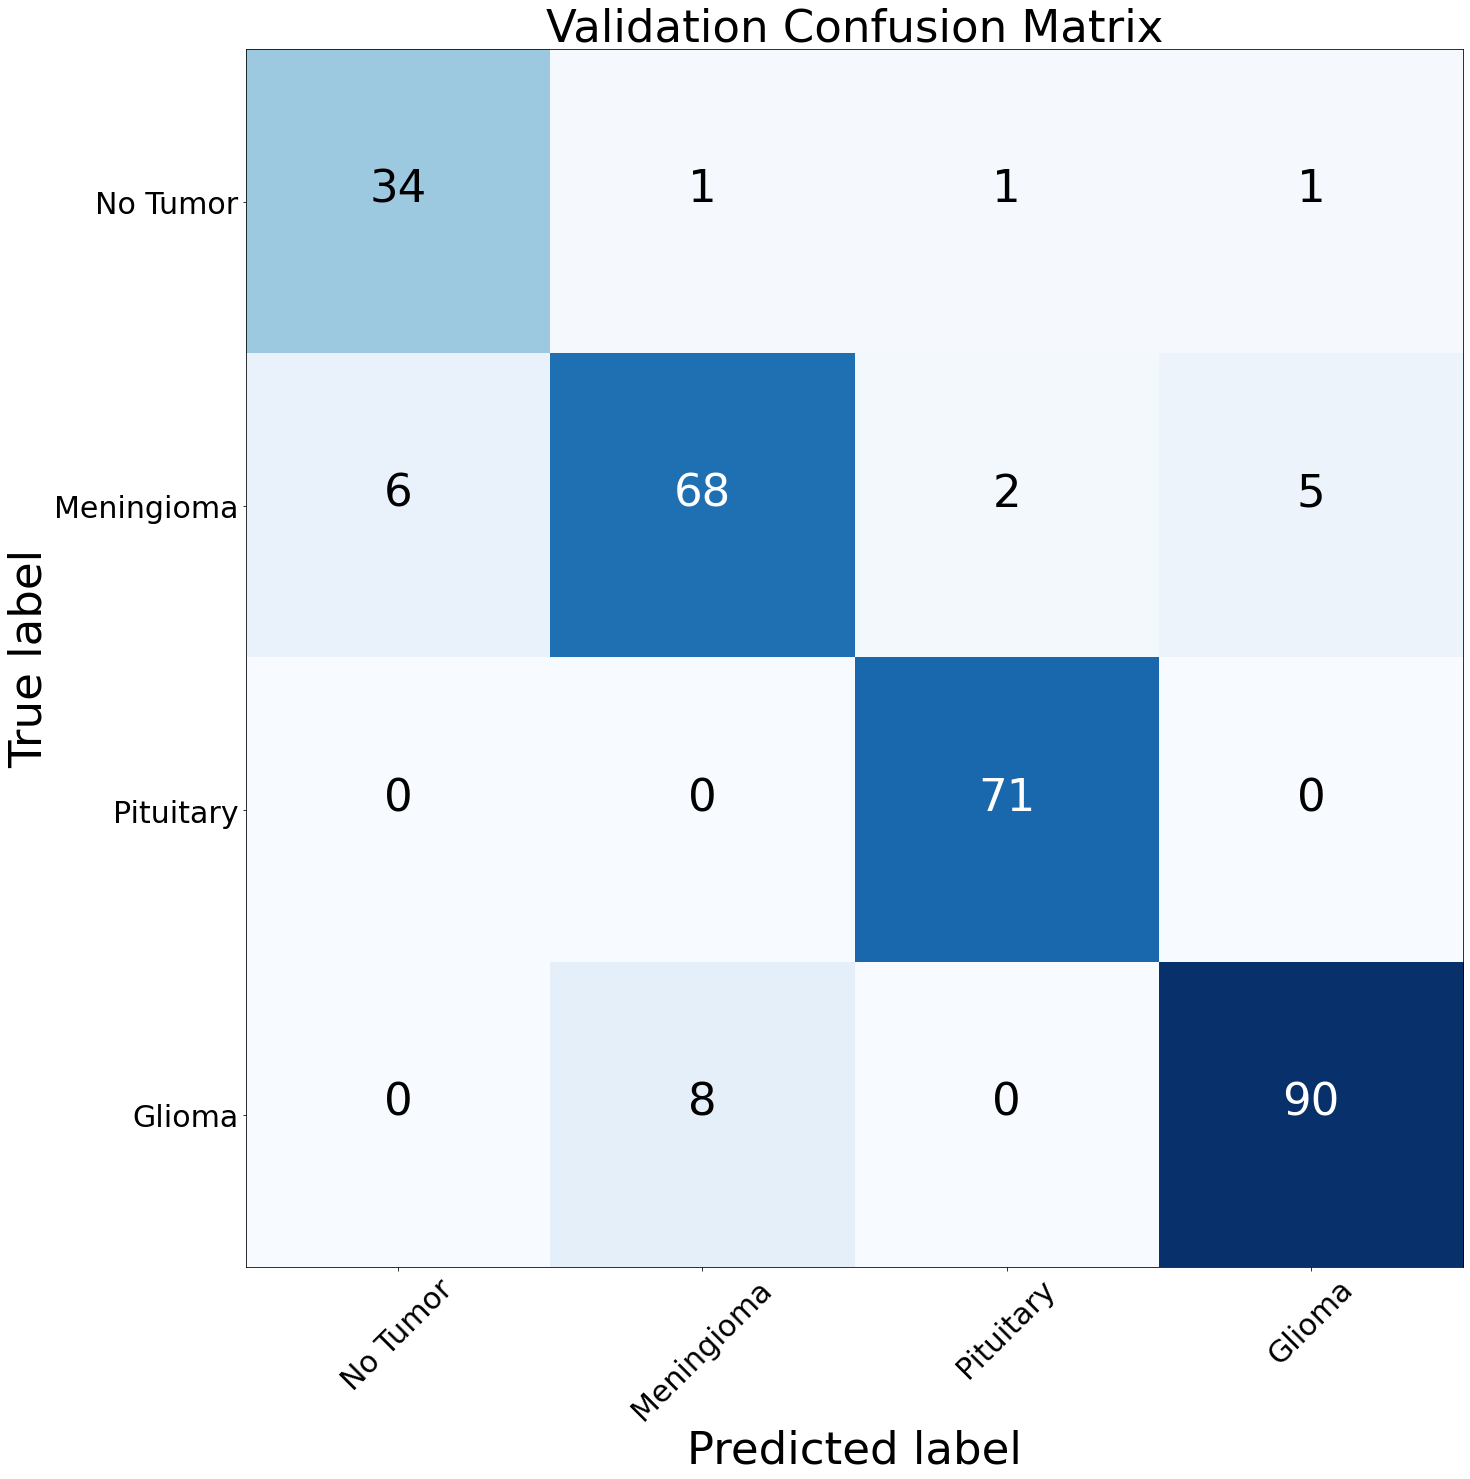

In [14]:
y_val_pred = model.predict(x_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

val_con_mat = confusion_matrix(y_val, y_val_pred_classes)


np.set_printoptions(precision=2)
plt.figure(figsize = (20,20))
plot_confusion_matrix(val_con_mat, classes = ["No Tumor", "Meningioma", "Pituitary", "Glioma"], title='Validation Confusion Matrix')

### Test Data Con Mat

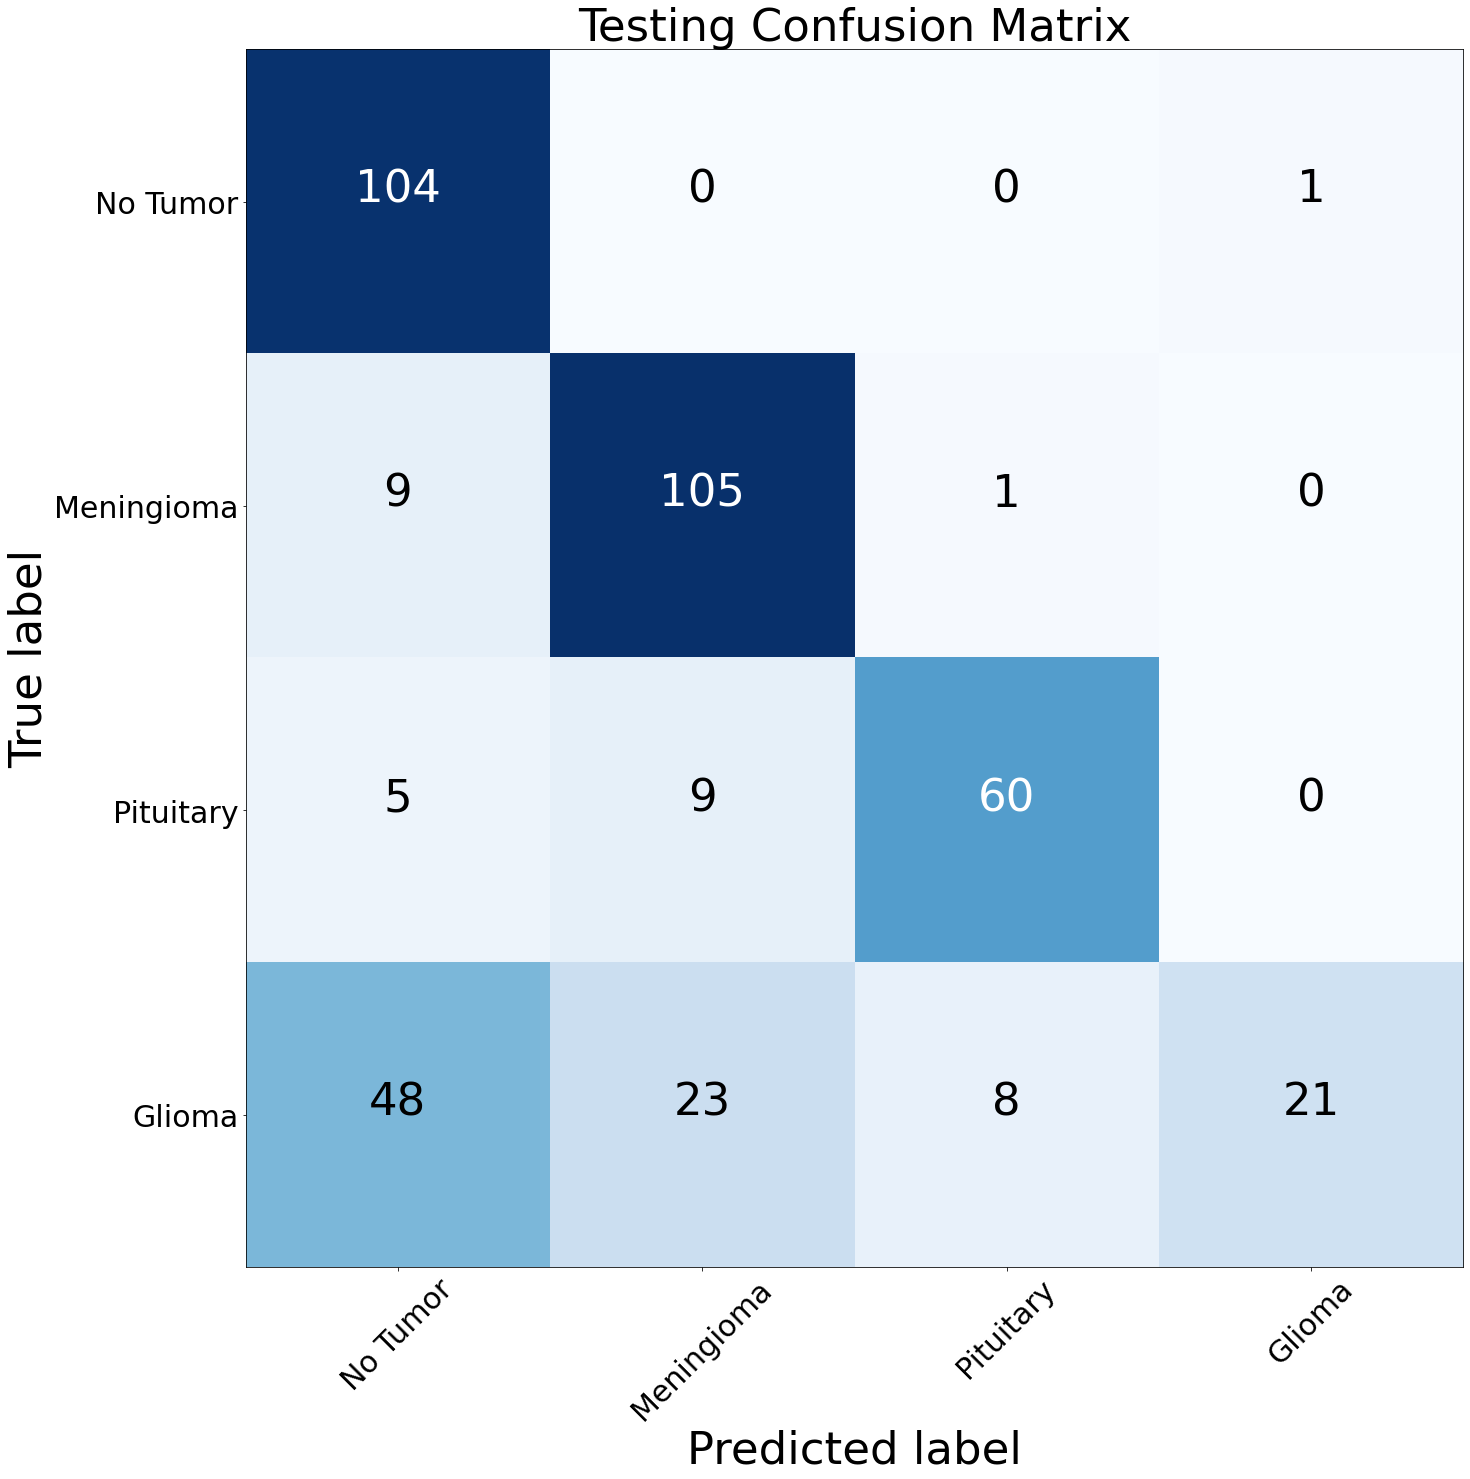

In [15]:
y_test_pred = model.predict(x_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

test_con_mat = confusion_matrix(y_test, y_test_pred_classes)


np.set_printoptions(precision=2)
plt.figure(figsize = (20,20))
plot_confusion_matrix(test_con_mat, classes = ["No Tumor", "Meningioma", "Pituitary", "Glioma"], title='Testing Confusion Matrix')